In [1]:
import gzip
import json
import pickle
import scipy.sparse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from scipy import spatial
from tqdm.auto import tqdm
from lightfm import LightFM
from lightfm.evaluation import precision_at_k

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-j2v6myej because the default path (/home/i313924/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
THREADS = 8

In [3]:
model = pd.read_pickle('/pio/scratch/1/i313924/lightfm_data/warp_model_1000_epochs_slim.pkl')

## Precision

In [6]:
interactions = scipy.sparse.load_npz('/pio/scratch/1/i313924/lightfm_data/slim_interactions.npz')

In [ ]:
# Super time-consuming: https://github.com/lyst/lightfm/issues/510
precision_at_k(model, interactions, k=5, num_threads=THREADS).mean()

## ABX

In [4]:
dataset = pd.read_pickle('/pio/scratch/1/i313924/lightfm_data/slim_dataset.pkl')
abx_tests = pd.read_json('/pio/scratch/1/i313924/test_ABX_slim', lines=True)

In [5]:
abx_tests

,A,B,X,category_AX,category_B
0,B00W9QTX3S,B00QKHWXOS,B00STZXEV0,Women,Girls
1,B00I7Q52NE,B00KAGTK2S,B00178M5M0,Luggage & Travel Gear,Novelty & More
2,B00N9HXOAE,B00RSWNGPO,B000NJQU2A,Men,Novelty & More
3,B00H7SBIAO,B01DAL9I6W,B004N639D2,Boys,Women
4,B0078IRRSA,B00EW148GU,B0035P3V0I,Women,Girls
...,...,...,...,...,...
9995,B00QG6OV20,B002MPPV8W,B0136IOUCG,Boys,Men
9996,B00JKS0QJ8,B00C766FY0,B00CIBECSA,Women,Novelty & More
9997,B007IVAC7U,B00CBSVT5E,B00BEKARM6,Novelty & More,Luggage & Travel Gear
9998,B00KTYKL0G,B010UPVKF8,B01E1S94LM,Men,Women


In [6]:
def get_item_embedding(model, dataset, asin):
    item_id = dataset.mapping()[2][asin]
    return model.item_embeddings[item_id]

In [7]:
A = np.zeros((10000, 100))
B = np.zeros((10000, 100))
X = np.zeros((10000, 100))

In [8]:
for i, test in tqdm(abx_tests.iterrows()):
    A[i, :] = get_item_embedding(model, dataset, test["A"])
    B[i, :] = get_item_embedding(model, dataset, test["B"])
    X[i, :] = get_item_embedding(model, dataset, test["X"])

0it [00:00, ?it/s]

In [9]:
dist_A = ((A - X)**2).sum(axis=1)
dist_B = ((B - X)**2).sum(axis=1)

In [10]:
(dist_A < dist_B).mean()

0.5278

In [11]:
cos_dist_A = np.zeros(10000)
cos_dist_B = np.zeros(10000)
for i in tqdm(range(10000)):
    cos_dist_A[i] = spatial.distance.cosine(A[i, :], X[i, :])
    cos_dist_B[i] = spatial.distance.cosine(B[i, :], X[i, :])

  0%|          | 0/10000 [00:00<?, ?it/s]

In [12]:
(cos_dist_A < cos_dist_B).mean()

0.5709

## Embeddings PCA

In [13]:
item_embeddings = pd.DataFrame(model.item_embeddings)
user_embeddings = pd.DataFrame(model.user_embeddings)

In [14]:
embeddings = pd.concat([item_embeddings, user_embeddings], keys=['items', 'users'])

In [15]:
embeddings.loc["items"]

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.031628,0.062442,0.069973,-0.040008,0.019826,-0.036465,-0.033512,-0.039870,0.025743,-0.062973,...,0.072504,0.097756,0.112925,-0.109699,0.009116,0.077250,0.055970,0.108094,0.022485,-0.091556
1,0.323799,0.135032,0.113087,-0.145619,-0.567639,-0.163192,-0.105536,0.224775,-0.028643,0.043794,...,0.212855,-0.234406,-0.118132,-0.115892,-0.191333,-0.569469,-0.072354,0.030412,-0.503527,0.425182
2,-0.053212,-0.458363,-0.252471,0.139446,-1.353725,0.459981,-0.260116,0.199559,-0.274087,-0.613599,...,-0.044856,-0.848575,-0.411924,0.106487,-0.074189,0.713249,0.106727,-0.316887,0.004575,0.360514
3,0.257243,-0.284504,0.627053,-0.693120,-0.031552,0.291068,-0.146542,0.120174,0.137263,-0.973636,...,0.124696,0.215663,0.111235,0.567860,-0.672219,0.893310,0.229107,-0.767007,0.236556,0.130220
4,-0.409245,-0.103757,-0.123899,-0.097725,-0.167701,0.538313,0.075908,-0.163463,-0.344125,-0.112471,...,0.613647,-0.068671,0.242737,0.165632,0.461043,0.811938,-0.214254,0.240059,-0.023398,0.104696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206491,0.266304,-0.125618,-0.352094,-0.129069,-0.007607,-0.263528,-0.334750,0.127501,0.329961,0.237822,...,0.096424,-0.016469,-0.044097,-0.440578,0.221441,-0.268421,0.100103,0.017649,0.068614,-0.511962
206492,0.376137,0.070992,0.292020,0.387898,0.365903,-0.424668,0.163044,-0.692443,0.252349,-0.634610,...,0.260176,-0.418479,0.480795,-0.409813,0.392215,0.370115,-0.055704,-0.559663,-0.420275,0.116071
206493,-0.278831,0.307551,0.516886,0.263859,0.033718,-0.173441,0.382026,-0.002616,-0.177777,0.416760,...,0.039264,0.144162,0.190634,-0.174879,-0.406849,-0.117475,0.304083,0.164231,-0.148875,-0.001967
206494,-0.135174,-0.069855,0.312535,-0.175889,-0.232956,0.166773,0.187233,0.172999,0.054587,0.114899,...,-0.330696,0.148545,0.216363,-0.182935,0.609759,-0.043774,-0.070556,-0.140660,-0.040087,0.128009


In [16]:
pca = PCA(n_components=2)
pca.fit(embeddings)

PCA(n_components=2)

In [17]:
reduced_item_embeddings = pd.DataFrame(pca.transform(embeddings.loc["items"]))
reduced_user_embeddings = pd.DataFrame(pca.transform(embeddings.loc["users"]))

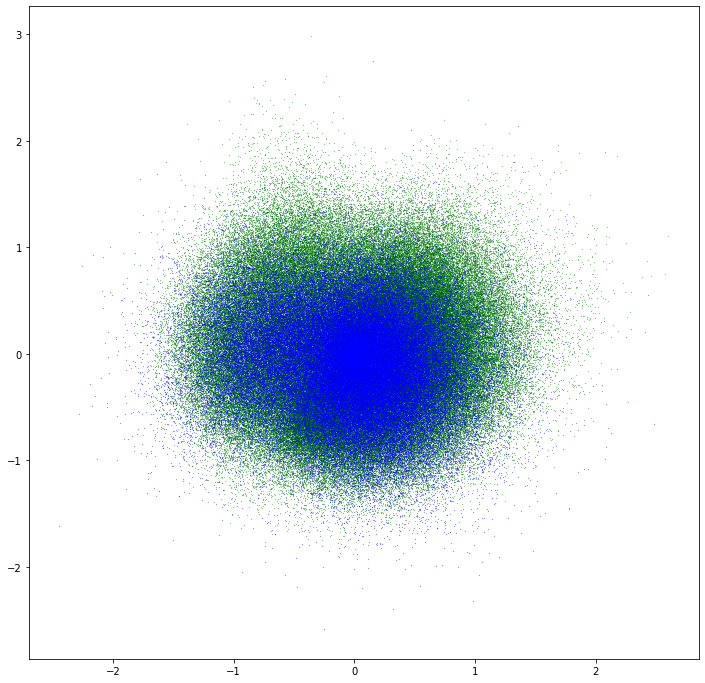

In [18]:
plt.figure(figsize=(12, 12))
plt.scatter(reduced_item_embeddings[0], reduced_item_embeddings[1], c='green', s=0.03)
plt.scatter(reduced_user_embeddings[0], reduced_user_embeddings[1], c='blue', s=0.03)

In [19]:
reduced_item_embeddings

,0,1
0,-0.237764,-0.546676
1,0.003931,0.815810
2,-0.454935,0.564229
3,0.504404,0.185068
4,0.308299,-0.673607
...,...,...
206491,-0.862848,-0.879313
206492,0.357509,-1.204256
206493,0.373296,-0.077936
206494,-0.326582,0.118494


In [20]:
item_mapping = {v: k for k, v in dataset.mapping()[2].items()}
user_mapping = {v: k for k, v in dataset.mapping()[0].items()}

In [21]:
reduced_item_embeddings = reduced_item_embeddings.rename(index=item_mapping)

In [22]:
categories = pd.read_json('/pio/scratch/1/recommender_systems/interim/Amazon/meta_Clothing_Shoes_and_Jewelry_categories.json', lines=True)

In [23]:
reduced_item_embeddings = reduced_item_embeddings.join(categories.set_index('asin'))

In [24]:
reduced_item_embeddings.columns = ['0', '1', 'category_1', 'category_2']

<AxesSubplot:xlabel='0', ylabel='1'>

/pio/scratch/1/i313924/miniconda3/envs/venv/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


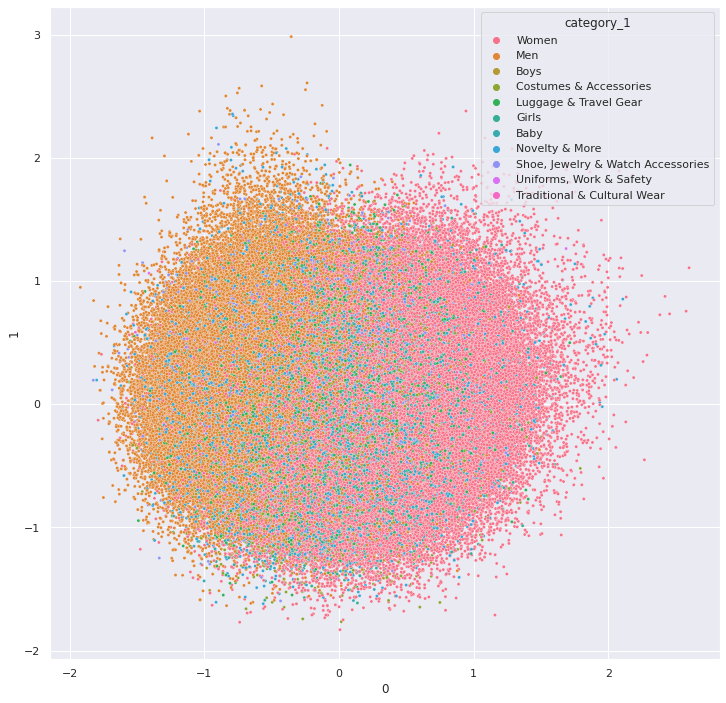

In [25]:
sns.set(rc={'figure.figsize':(12,12)})
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings, hue='category_1', s=10)

<AxesSubplot:xlabel='0', ylabel='1'>

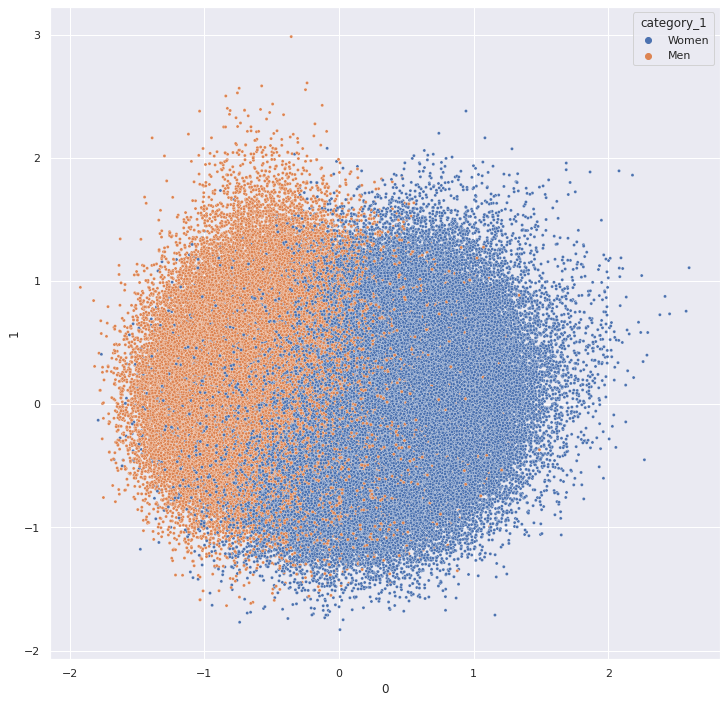

In [26]:
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings[reduced_item_embeddings['category_1'].isin(['Women', 'Men'])], hue='category_1', s=10)